In [5]:
import json
import numpy as np
import os
import random
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

DATA_DIR = '{}/research_backup/data'.format(os.getenv('HOME'))
splits = ['dev']

# Load SQUAD formatted hotpot data
hotpot_data_folder = 'hotpot-squad'
data = {}
for split in splits:
    with open(f'{DATA_DIR}/{hotpot_data_folder}/{split}.json') as f:
        data[split] = json.load(f)

In [152]:
model_no = 1
beam = 16
length_penalty = 2.0

subqs_dir = f'{DATA_DIR}/hotpot-all.umt.comparison.paired.model={model_no}.beam={beam}.lp={length_penalty}'

subqs = {}
subas = {}
qtype = 'c'
total_raw_subqs = 0
raw_subas = {}
for split in splits:
    with open(f'{subqs_dir}/{split}.json') as f:
        raw_subqs = json.load(f)
    with open(f'{subqs_dir}/bert_predict.nbest=10/{split}.nbest_predictions.json') as f:
        raw_subas.update(json.load(f))
    for example in raw_subqs['data']:
        for paragraph in example['paragraphs']:
            qid = paragraph['qas'][0]['id'].split('-')[0]
            subqs[qid] = subqs.get(qid, {})
            for qa in paragraph['qas']:
                total_raw_subqs += 1
                subqs[qid][qtype] = subqs[qid].get(qtype, [])
                subqs[qid][qtype].append(qa['question'])

num_subas = 0
num_missing_subas = 0
subas_c_qids = {k.split('-')[0] for k in raw_subas.keys()}
for qid in subas_c_qids:
    subas[qid] = subas.get(qid, {})
    subas[qid][qtype] = []
    for i in [0, 1]:
        subqid = qid + '-' + str(i)
        if subqid in raw_subas:
            subas[qid][qtype].append(raw_subas[subqid])
            num_subas += 1
        else:
            num_missing_subas += 1
suba_probs = np.array(suba_probs)
# suba_probs = np.array(np.array(suba_probs[i]) for i in suba_probs)
# suba_probs.sort()
print(total_raw_subqs, num_subas, num_missing_subas)

2930 2930 44


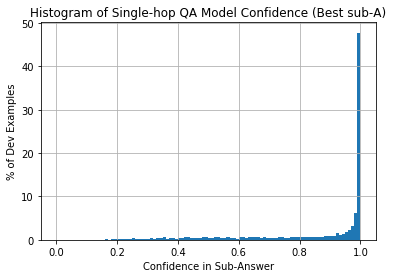

In [149]:
# Plot histogram of sub-A model confidence
plt.hist(suba_probs, 100, density=True, range=(0,1))
plt.xlabel('Confidence in Sub-Answer')
plt.ylabel('% of Dev Examples')
plt.title('Histogram of Single-hop QA Model Confidence (Best sub-A)')
plt.grid(True)
plt.show()

In [161]:
data_copy.keys()

dict_keys(['dev'])

In [168]:
len(subqs)

1487

In [172]:
for si in range(10):
    for sj in range(10):
        suba_rank = [si, sj]
        use_subq = True
        use_suba = True
        skip_qtypes = ['b', 'i', 'o']
        limitsubqs = True

        q_start = '//'
        a_start = '/'
        skip_qtypes.sort()

        assert use_subq or use_suba, 'Adding no sub-Qs or sub-As. Are you sure?'
        question_augmenteds = []
        print('Copying data...')
        data_copy = deepcopy(data)
        for split in data_copy.keys():
            for article_no in tqdm(range(len(data_copy[split]['data']))):
                for paragraph_no in range(len(data_copy[split]['data'][article_no]['paragraphs'])):
                    if '_id' not in data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]:
                        continue  # SQuAD question: skip
                    qid = data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['_id']
                    for qa_no in range(len(data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'])):
                        question_augmented = data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'][qa_no]['question'].strip()
                        if use_suba and ('o' not in skip_qtypes):
                            question_augmented += ' ' + a_start + ' ' + subas[qid]['o'][0].strip()
                        for qtype in {'b', 'i', 'c'}:
                            if (qtype not in skip_qtypes) and (qid in subqs) and (qtype in subqs[qid]):
                                if limitsubqs and ('c' in subqs[qid]) and (qtype in {'b', 'i'}):
                                    print('Limited!')
                                    continue  # don't add b/i subqs if there's a c decomposition
                                for subq_no, (subq, suba) in enumerate(zip(subqs[qid][qtype], subas[qid][qtype])):
                                    if use_subq:
                                        question_augmented += ' ' + q_start + ' ' + subq.strip()
                                    if use_suba and (len(suba) > suba_rank[subq_no]):
                                        question_augmented += ' ' + a_start + ' ' + suba[suba_rank[subq_no]]['text'].strip()
                                        data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'][qa_no]['probability_subas'] = data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'][qa_no].get('probability_subas', [])
                                        data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'][qa_no]['probability_subas'].append(suba[suba_rank[subq_no]]['probability'])
                        data_copy[split]['data'][article_no]['paragraphs'][paragraph_no]['qas'][qa_no]['question'] = question_augmented
                        question_augmenteds.append(question_augmented)
                    
        qlens = []
        for question_augmented in question_augmenteds:
            qlens.append(len(question_augmented.split()))
        qlens = np.array(qlens)
        print('Mean # Tokens:', int(round(1.2 * qlens.mean())))
        print('# Examples:', len(qlens))

        qlens.sort()
        print('90 %-ile # Tokens:', int(round(1.2 * qlens[int(.9 * qlens.size)])))
        print('99 %-ile # Tokens:', int(round(1.2 * qlens[int(.99 * qlens.size)])))

        input_name = 'q'
        if use_subq:
            input_name += '-predsubqs'
        if use_suba:
            input_name += '-predsubas'

        save_dir = f'{subqs_dir}.{input_name}.ensemble_subas'
        print(f'Saving to {save_dir}...')
        os.makedirs(save_dir, exist_ok=True)
        for split in splits:
            with open(f'{save_dir}/{split}.suba1={suba_rank[0]}.suba2={suba_rank[1]}.json', 'w') as f:
                json.dump(data_copy[split], f, indent=2)

Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30962.84it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 60
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30900.33it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 60
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31006.71it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30969.17it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 28460.49it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 27441.60it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32830.71it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30802.75it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31564.45it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31614.46it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31752.27it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31791.70it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33072.08it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 29603.12it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32994.38it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32656.83it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31545.33it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34603.71it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12616.07it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33213.97it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34348.40it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35223.26it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 36226.25it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33898.04it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34040.89it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12483.53it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33967.93it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32421.56it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34233.51it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33544.33it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33265.95it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 60
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34839.64it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 13135.50it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34366.67it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30830.69it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34186.14it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33682.06it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33971.03it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34348.09it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34609.19it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33987.65it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34930.23it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34845.67it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32179.50it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32352.02it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 27937.34it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31721.80it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31072.75it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32348.53it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 31932.44it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 11853.87it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 40
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32949.79it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33639.94it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32098.34it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 11984.96it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33396.50it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33144.12it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32761.77it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33449.59it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33071.48it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33072.25it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32562.43it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 11985.62it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33458.52it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32380.65it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33442.60it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12276.76it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34539.13it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32676.97it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32631.90it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30258.30it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32763.22it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32622.82it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12288.38it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33901.43it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32122.39it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34726.78it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33115.39it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 65
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33897.38it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 65
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35082.13it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 65
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34590.36it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 61
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34435.54it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35609.36it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12507.23it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34743.75it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35085.91it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35475.33it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34785.08it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32307.10it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 32834.61it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 29892.25it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 12462.49it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 62
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35019.21it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34303.92it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 35148.91it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34375.19it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 41
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 33832.51it/s]


Mean # Tokens: 24
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 34136.55it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 65
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 30824.17it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...
Copying data...


100%|██████████| 7440/7440 [00:00<00:00, 11618.45it/s]


Mean # Tokens: 25
# Examples: 73700
90 %-ile # Tokens: 42
99 %-ile # Tokens: 64
Saving to /Users/ethanperez/research_backup/data/hotpot-all.umt.comparison.paired.model=1.beam=16.lp=2.0.q-predsubqs-predsubas.ensemble_subas...


In [ ]:
### Generate (subset of) comparison-only Q's

In [7]:
data_copy = deepcopy(data)
num_comp_qs = {}
comp_data = {}
for split in ['train']:
    num_comp_qs[split] = 0
    comp_data[split] = {'data': [], 'version': data_copy[split]['version']}
    for article in data_copy[split]['data']:
        is_comp_paragraph = False
        for paragraph in article['paragraphs']:
            if paragraph.get('_id') in subas_c_qids:
                is_comp_paragraph = True
                break
        if is_comp_paragraph:
            comp_data[split]['data'].append(article)
            num_comp_qs[split] += 1
print('num_comp_qs:', num_comp_qs)

num_comp_qs: {'train': 17435}


In [9]:
save_dir = f'{DATA_DIR}/hotpot-all'
comp_save_dir = f'{save_dir}.comparison-only.num-train=' + str(num_comp_qs['train'])
print(f'Saving to {comp_save_dir}...')
os.makedirs(comp_save_dir, exist_ok=False)
for split in splits:
    with open(f'{comp_save_dir}/{split}.json', 'w') as f:
        json.dump((comp_data if split == 'train' else data_copy)[split], f, indent=2)

Saving to /Users/ethanperez/research/data/hotpot-all.comparison-only.num-train=17435...


In [20]:
shuffled_qidxs_train = list(range(num_comp_qs['train']))
random.Random(42).shuffle(shuffled_qidxs_train)
train_data_frac = .015625

train_qidxs_subset = set(shuffled_qidxs_train[:round(len(shuffled_qidxs_train) * train_data_frac)])

num_comp_qs_filtered = {}
comp_data = {}
for split in ['train']:
    num_comp_qs_filtered[split] = 0
    comp_data[split] = {'data': [], 'version': data_copy[split]['version']}
    for article in data_copy[split]['data']:
        is_comp_paragraph = False
        for paragraph in article['paragraphs']:
            if paragraph.get('_id') in subas_c_qids:
                is_comp_paragraph = True
                break
        if is_comp_paragraph:
            if num_comp_qs_filtered[split] in train_qidxs_subset:
                comp_data[split]['data'].append(article)
            num_comp_qs_filtered[split] += 1
print('Train Comp Qs remaining:', len(comp_data['train']['data']))

Train Comp Qs remaining: 272


In [21]:
comp_save_dir = f'{save_dir}.comparison-only.num-train=' + str(len(comp_data['train']['data']))
print(f'Saving to {comp_save_dir}...')
os.makedirs(comp_save_dir, exist_ok=False)
for split in splits:
    with open(f'{comp_save_dir}/{split}.json', 'w') as f:
        json.dump((comp_data if split == 'train' else data_copy)[split], f, indent=2)

Saving to /Users/ethanperez/research/data/hotpot-all.comparison-only.num-train=272...
